### Incorporating Exogenous Variables



## **Incorporating Exogenous Variables**  
To improve traffic prediction accuracy, we incorporate **Turkish national holidays** as exogenous variables. Holidays such as **Republic Day, Eid al-Fitr, Eid al-Adha, and others** significantly influence traffic flow in Istanbul, causing noticeable fluctuations in congestion levels.  

## **Methodology**  
1. **Data Preprocessing**:  
   - Converting the dataset into a time series format.  
   - Handling missing values and ensuring data consistency.  
   - Creating a binary feature for Turkish holidays to capture their impact on traffic.  

2. **Exploratory Data Analysis (EDA)**:  
   - Identifying long-term trends and seasonal patterns in traffic congestion.  
   - Visualizing fluctuations in traffic intensity due to economic factors, weather conditions, and external events (e.g., holidays, weekends).  

3. **Model Selection and Training**:  
   - Using **SARIMAX** to account for both autoregressive and seasonal dependencies.  
   - Selecting optimal hyperparameters based on **AIC/BIC scores and residual diagnostics**.  

4. **Forecasting Future Traffic Trends**:  
   - Generating **daily traffic forecasts** for the coming periods.  
   - Analyzing projected trends and the impact of major holidays on traffic congestion in Istanbul’s European side.  

## **Expected Outcomes**  
- A robust traffic forecast to support urban mobility planning and policy decisions.  
- Insights into seasonal fluctuations in Istanbul’s traffic patterns.  
- A clearer understanding of how holidays influence congestion, helping optimize transportation strategies.




# Data Collection and Preprocessing

In [288]:
# RUN THIS CELL
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import itertools
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import seaborn as sns

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # 
from statsmodels.tsa.seasonal import seasonal_decompose      #
from pmdarima import auto_arima                              # 

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")





In [289]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("leonardo00/istanbul-traffic-index")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\caioe\.cache\kagglehub\datasets\leonardo00\istanbul-traffic-index\versions\70


In [290]:

files = os.listdir(path)
print("Files:", files)

Files: ['istanbul_traffic.csv']


In [291]:
file_name = 'istanbul_traffic.csv'

In [292]:
file_path = os.path.join(path, file_name)
df = pd.read_csv(file_path)


In [293]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838878 entries, 0 to 838877
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   datetime  838878 non-null  object
 1   TI        838878 non-null  int64 
 2   TI_An     838878 non-null  int64 
 3   TI_Av     838878 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 25.6+ MB


In [294]:
df.head()

,datetime,TI,TI_An,TI_Av
0,2022-11-01 01:10:00,4,1,8
1,2022-11-01 01:13:00,4,1,8
2,2022-11-01 01:14:00,4,1,8
3,2022-11-01 01:15:00,4,1,8
4,2022-11-01 01:16:00,4,1,8


In [295]:
df.tail()

,datetime,TI,TI_An,TI_Av
838873,2025-02-12 20:28:00,33,31,35
838874,2025-02-12 20:32:00,33,29,35
838875,2025-02-12 20:36:00,29,26,33
838876,2025-02-12 20:40:00,26,22,29
838877,2025-02-12 20:44:00,26,20,29


In [296]:
df = df[['datetime', 'TI_Av']]

Creating a dataframe of holidays

In [297]:
import holidays
from datetime import date


turkey_holidays = holidays.Turkey(years=range(2021, 2026))

holiday_list = [(date, name) for date, name in turkey_holidays.items()]


df_holidays = pd.DataFrame(holiday_list, columns=['Date', 'Holiday'])

df_holidays.head()

,Date,Holiday
0,2021-01-01,Yılbaşı
1,2021-04-23,Ulusal Egemenlik ve Çocuk Bayramı
2,2021-05-01,Emek ve Dayanışma Günü
3,2021-05-19,"Atatürk'ü Anma, Gençlik ve Spor Bayramı"
4,2021-07-15,Demokrasi ve Millî Birlik Günü


Preparing our dataframe df to time series

In [298]:
df = df.rename(columns={'datetime': 'Date'})
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.floor('D')  




In [299]:
df_holidays['Date'] = pd.to_datetime(df_holidays['Date'])

Let's create a column in df of Holidays

In [300]:
df_merged = df.merge(df_holidays, on='Date', how='left', indicator=True)

In [301]:
df['Holiday'] = df_merged['_merge'].apply(lambda x: 1 if x == 'both' else 0)

Df is described by hour and minutes, so, I will analize it as 

In [302]:

df.set_index('Date', inplace=True)

df = df.resample('D').sum()

In [303]:
df = df.loc[:'2024-04-05']

In [304]:
df.tail()

,TI_Av,Holiday
Date,,
2024-04-01,36435,0
2024-04-02,13061,0
2024-04-03,50472,0
2024-04-04,54099,0
2024-04-05,53365,0


In [305]:
df['Holiday'] = df['Holiday'].apply(lambda x: 1 if x > 0 else 0)

It's easy to observe less traffic in Holidays

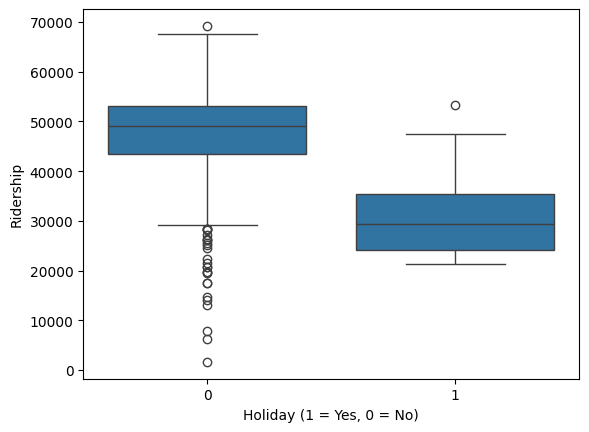

In [306]:
sns.boxplot(x='Holiday', y='TI_Av', data=df)


plt.xlabel('Holiday (1 = Yes, 0 = No)')
plt.ylabel('Ridership')
plt.show()

In [307]:
df.head()

,TI_Av,Holiday
Date,,
2022-11-01,50434,0
2022-11-02,51681,0
2022-11-03,49935,0
2022-11-04,50408,0
2022-11-05,46977,0


# Chart

In [308]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots



mean = df['TI_Av'].mean()
rolling_mean = df['TI_Av'].rolling(7).mean()


fig = make_subplots(rows=1, cols=1)


fig.add_trace(go.Scatter(
    x=df.index, 
    y=df['TI_Av'], 
    mode='lines', 
    name="Ridership", 
    line=dict(color='black'),
    hovertemplate='<b>Data:</b> %{x|%d-%m-%Y}<br><b>Ridership:</b> %{y}<extra></extra>'
))

fig.add_trace(go.Scatter(x=df.index, y=[mean] * len(df), mode='lines', name=f"General Avg ({mean:.2f})", line=dict(dash='dash', color='blue')))
fig.add_trace(go.Scatter(x=df.index, y=rolling_mean, mode='lines', name="Moving Avg", line=dict(color='purple')))




event_dates = df[df['Holiday'] == 1]
for event_date in event_dates.index:
    fig.add_vline(x=event_date, line_width=1, line_color='red')


fig.update_layout(
    title="Ridership in European Instabul",
    xaxis_title="Date",
    yaxis_title="Total",
    legend_title="Legend",
    hovermode='x unified'
)

fig.show()

# Correlation between Weekly_sales and Holiday, including lags.

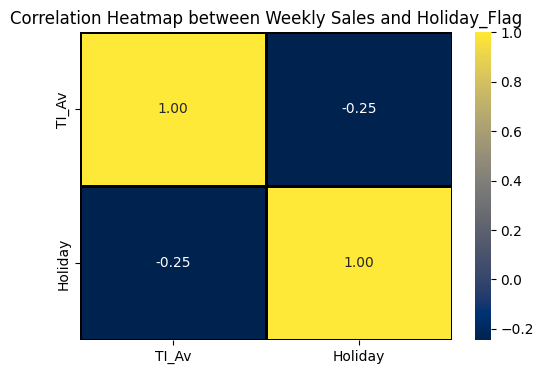

In [309]:
import seaborn as sns
import matplotlib.pyplot as plt


corr_matrix = df[['TI_Av', 'Holiday']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="cividis", fmt=".2f", linewidths=1, linecolor='black')
plt.title("Correlation Heatmap between Weekly Sales and Holiday_Flag")
plt.show();



Well, it's not an strong relationship, anyway, it has some impact in traffic

In [310]:
from statsmodels.tsa.stattools import grangercausalitytests

grangercausalitytests(df[['TI_Av', 'Holiday']], maxlag=7);



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0037  , p=0.0837  , df_denom=518, df_num=1
ssr based chi2 test:   chi2=3.0211  , p=0.0822  , df=1
likelihood ratio test: chi2=3.0124  , p=0.0826  , df=1
parameter F test:         F=3.0037  , p=0.0837  , df_denom=518, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1365  , p=0.0165  , df_denom=515, df_num=2
ssr based chi2 test:   chi2=8.3533  , p=0.0154  , df=2
likelihood ratio test: chi2=8.2869  , p=0.0159  , df=2
parameter F test:         F=4.1365  , p=0.0165  , df_denom=515, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1023  , p=0.0264  , df_denom=512, df_num=3
ssr based chi2 test:   chi2=9.4341  , p=0.0240  , df=3
likelihood ratio test: chi2=9.3494  , p=0.0250  , df=3
parameter F test:         F=3.1023  , p=0.0264  , df_denom=512, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.7073  , p=0.0297  

Periodogram to discover a good period to analyze.

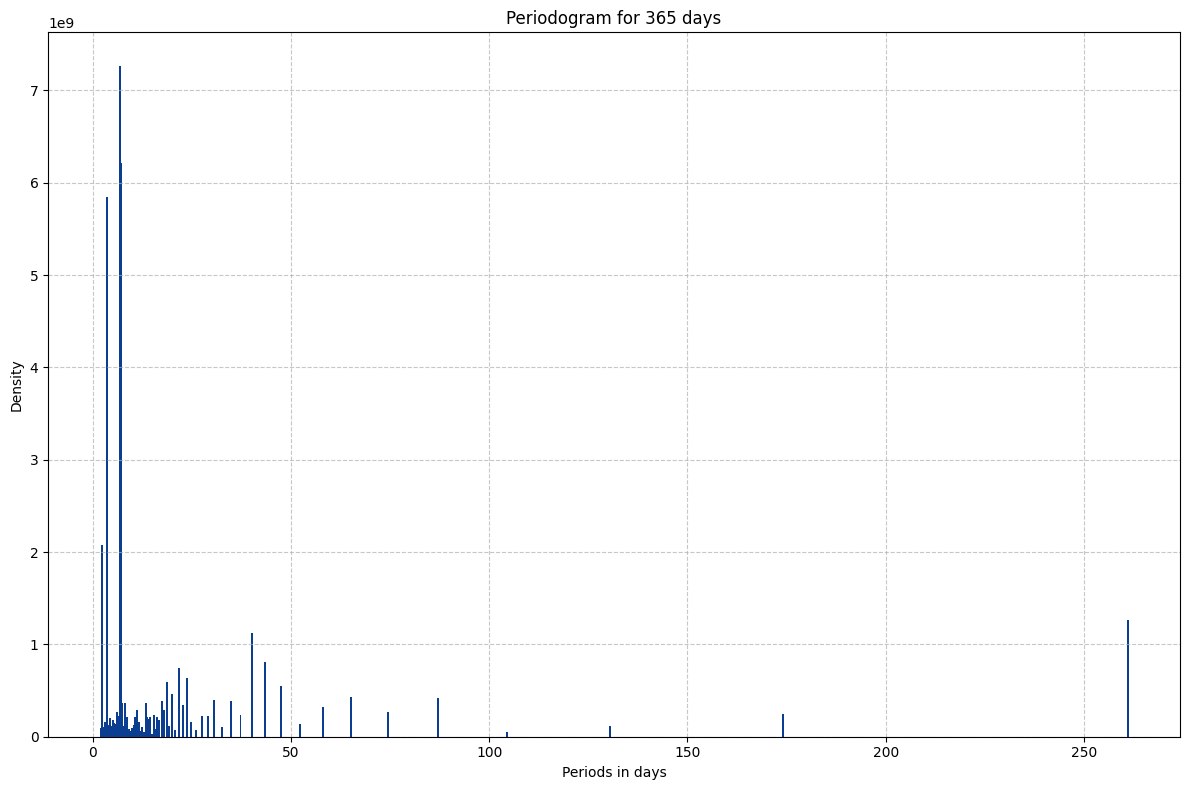

In [311]:

from scipy.signal import periodogram


frequencies, power = periodogram(df['TI_Av'])

# Ignoring zero frequence
periods = 1 / frequencies[1:]  
power = power[1:]

# Filtering
mask = (np.isfinite(periods)) & (periods <= 366)
periods_limited = periods[mask]
power_limited = power[mask]


plt.figure(figsize=(12, 8))  
plt.bar(periods_limited, power_limited, color='#0b3d91', width=0.5)  


plt.title('Periodogram for 365 days')
plt.xlabel('Periods in days')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.7)  
plt.tight_layout() 

plt.show()




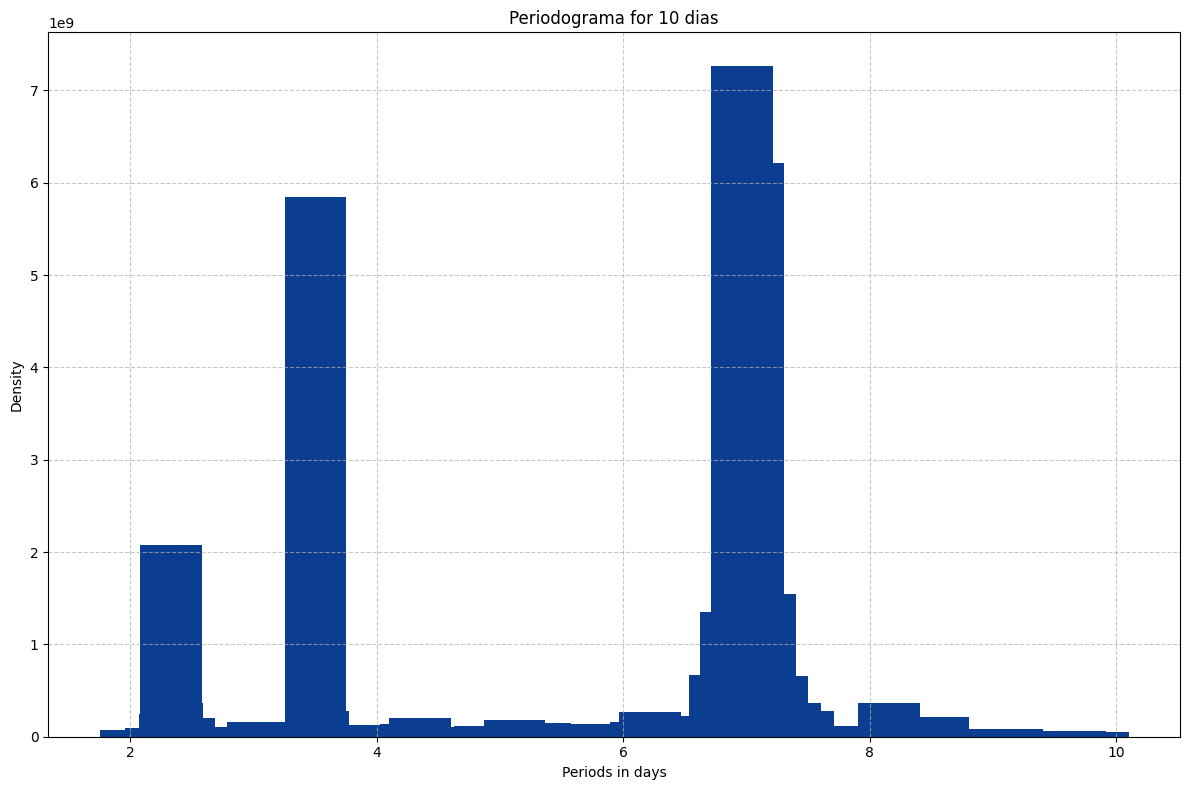

In [312]:
# Filtrando períodos finitos e menores ou iguais a 365 dias
mask = (np.isfinite(periods)) & (periods <= 10)
periods_limited = periods[mask]
power_limited = power[mask]

# Criando o gráfico de barras com Matplotlib
plt.figure(figsize=(12, 8))  # Define o tamanho da figura
plt.bar(periods_limited, power_limited, color='#0b3d91', width=0.5)  # Barras com cor azul escura

# Personalizando o gráfico
plt.title('Periodograma for 10 dias')
plt.xlabel('Periods in days')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.7)  # Adiciona grade para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposições

# Exibindo o gráfico
plt.show()

7 days looks nice.

# Seasonal Decomposition

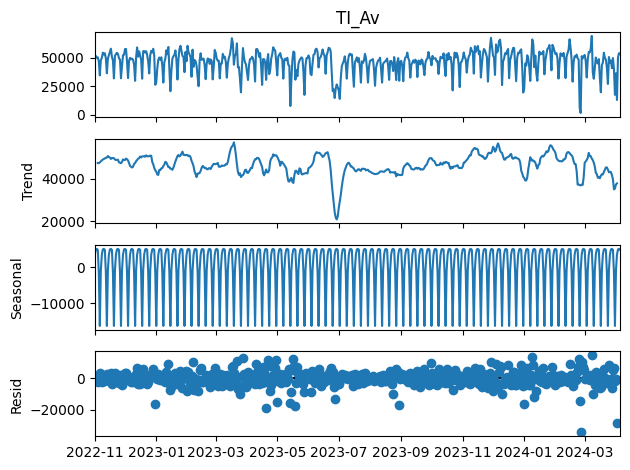

In [313]:
result = seasonal_decompose(df['TI_Av'], model='additive', period=7)
result.plot();

Time Series above seems to have a pattern, it seems to be stationary and seasonal.

# Stationarity Analysis

Stationarity analysis is a crucial step in time series modeling, as many forecasting techniques require the series to be stationary. A time series is considered stationary when its statistical properties, such as mean and variance, do not change over time. To check for stationarity, the Augmented Dickey-Fuller (ADF) test can be performed, which tests for the presence of a unit root in the time series. If the series passes the ADF test, it indicates that the series is stationary, while a negative result suggests that the series is non-stationary and may require transformations, such as differencing, to become stationary.

In [314]:
import pandas as pd

def auto_differencing_df(series, n):
   
    differenced_series = pd.DataFrame(index=series.index)

   
    differenced_series['Original'] = series

    
    for i in range(1, n + 1):
        differenced_series[f"Differenced_{i}"] = series.diff(i)

    
    differenced_series = differenced_series.dropna()

    return differenced_series




In [315]:

n = 3


differenced_df = auto_differencing_df(df["TI_Av"], n)


differenced_df.head()

,Original,Differenced_1,Differenced_2,Differenced_3
Date,,,,
2022-11-04,50408,473.0,-1273.0,-26.0
2022-11-05,46977,-3431.0,-2958.0,-4704.0
2022-11-06,34625,-12352.0,-15783.0,-15310.0
2022-11-07,47898,13273.0,921.0,-2510.0
2022-11-08,49958,2060.0,15333.0,2981.0


adf

In [316]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def adf_test_summary(series, max_diff=5):
    results = []

    for d in range(0, max_diff + 1):
        # Differentiation
        if d == 0:
            series_diff = series  # Série original
            diff_label = "Original"
        else:
            series_diff = series.diff(d).dropna()  # Aplica diferenciação e remove NaN
            diff_label = f"Differentiation {d}"
        
        # ADF test
        adf_result = adfuller(series_diff, autolag="AIC")
        
        # Values of ADF
        result_dict = {
            "Differentiation": diff_label,
            "ADF Statistic": adf_result[0],
            "p-value": adf_result[1],
            "Lags Used": adf_result[2],
            "Number of Observations": adf_result[3],
            "Critical Value (1%)": adf_result[4]["1%"],
            "Critical Value (5%)": adf_result[4]["5%"],
            "Critical Value (10%)": adf_result[4]["10%"],
            "Stationary?": "Yes" if adf_result[1] < 0.05 else "No"
        }
        
        results.append(result_dict)
        
        # Break if reached adf less than 0.05
        if adf_result[1] < 0.05:
            break

    results_df = pd.DataFrame(results)
    return results_df


In [317]:
adf_results = adf_test_summary(df["TI_Av"], max_diff=3)


adf_results

,Differentiation,ADF Statistic,p-value,Lags Used,Number of Observations,Critical Value (1%),Critical Value (5%),Critical Value (10%),Stationary?
0,Original,-4.678209,0.000092,14,507,-3.443314,-2.867258,-2.569815,Yes


The original serie is stationary.

# Seasonality Analysis

# Subtracting the Seasonal Component  

Let's analyze two differenciations of 7 days-period

In [318]:


df_seasonal = df.copy()

df_seasonal["diff_season"] = df['TI_Av'].diff(7)
df_seasonal = df_seasonal.dropna(subset=['diff_season'])







In [319]:

# Supondo que 'differenced_df' já esteja definido e possua a coluna 'Differenced_1'
mean = df_seasonal["diff_season"].mean()
std = df_seasonal["diff_season"].std()

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df_seasonal.index, y=df_seasonal['diff_season'], mode='lines', name="Differentiated values", line=dict(color='black')))
fig.add_trace(go.Scatter(x=df_seasonal.index, y=[mean] * len(df_seasonal), mode='lines', name=f"General Mean ({mean:.2f})", line=dict(dash='dash', color='blue')))
fig.add_trace(go.Scatter(x=df_seasonal.index, y=[mean + std] * len(df_seasonal), mode='lines', name="Standard Deviation", line=dict(color='orange', dash='dot')))
fig.add_trace(go.Scatter(x=df_seasonal.index, y=[mean - std] * len(df_seasonal), mode='lines', name="Standard Deviation", line=dict(color='orange', dash='dot')))

fig.update_layout(title="Differentiated Riderships", xaxis_title="Date", yaxis_title="Differentiated Riderships", legend_title="Legenda")
fig.show()

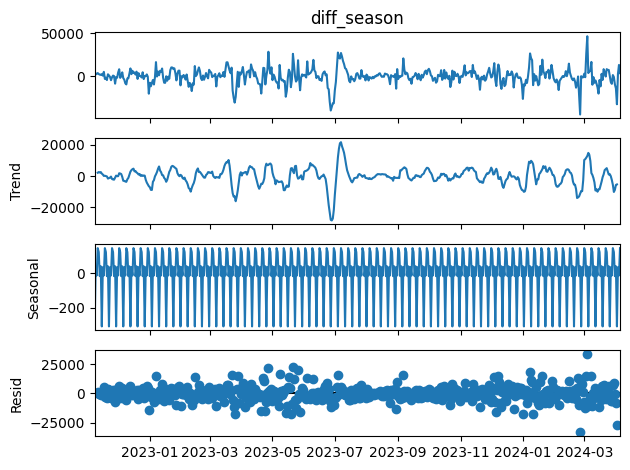

In [320]:
result = seasonal_decompose(df_seasonal["diff_season"] , model='additive', period=7)
result.plot();

First differentiation looks ambiguous wether seasonal or not. ACF/PACF could be more adequate to determine it.

In [321]:

df_seasonal_2 = df_seasonal.copy()
df_seasonal_2["sec_diff_season"] = df_seasonal['diff_season'].diff(7)
df_seasonal_2 = df_seasonal_2.dropna(subset='sec_diff_season')

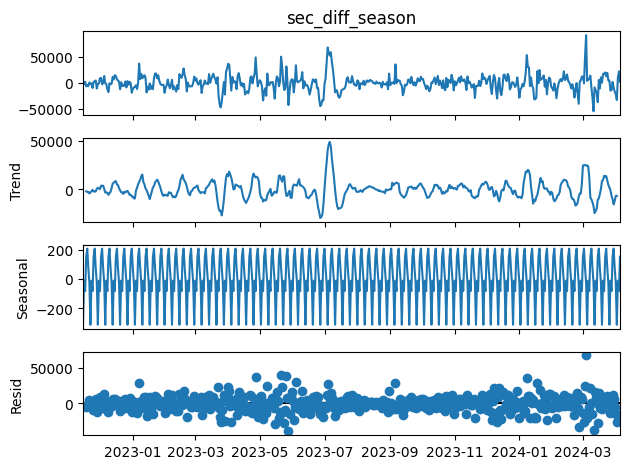

In [322]:
result = seasonal_decompose(df_seasonal_2["sec_diff_season"] , model='additive', period=7)
result.plot();

It looks more deseasonalized, but to be honest, ACF/PACF could be better to read it.

# Pattern Identification

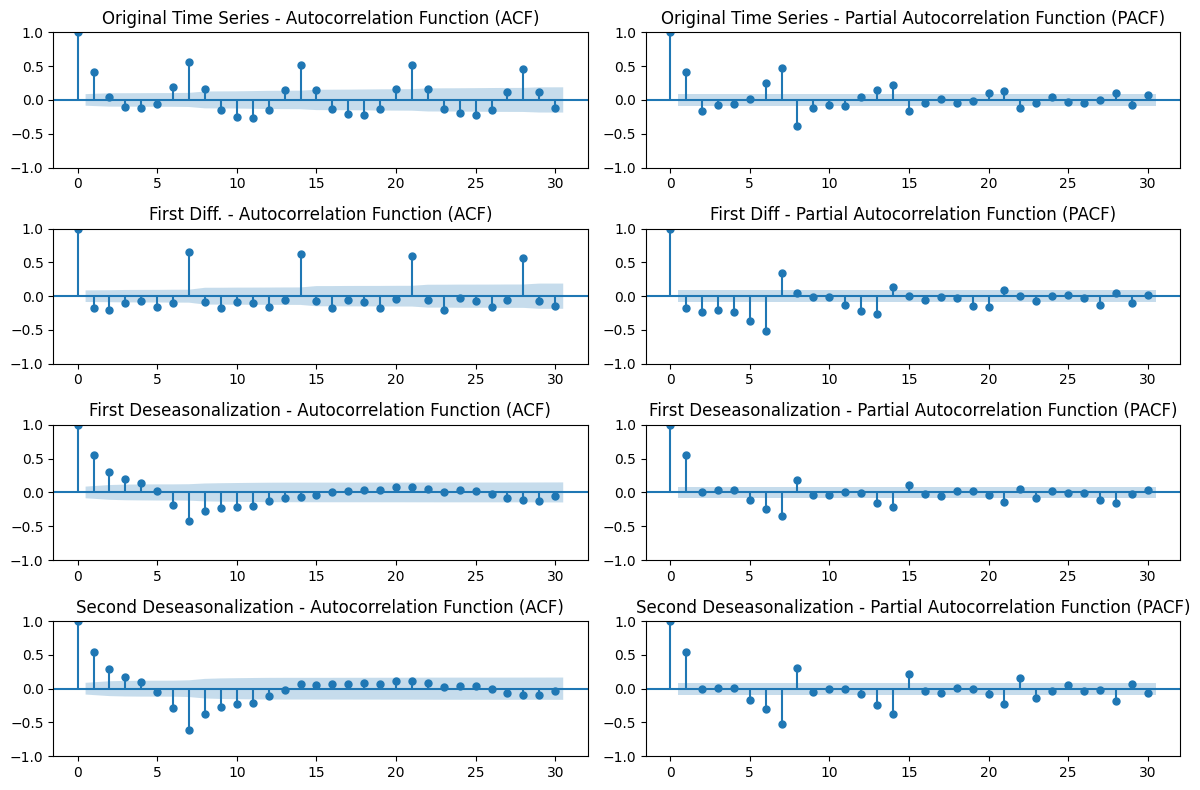

In [323]:

fig, axes = plt.subplots(4, 2, figsize=(12, 8))

plot_acf(df['TI_Av'], lags=30, ax=axes[0, 0])
axes[0, 0].set_title("Original Time Series - Autocorrelation Function (ACF)")

plot_pacf(df['TI_Av'], lags=30, ax=axes[0, 1])
axes[0, 1].set_title("Original Time Series - Partial Autocorrelation Function (PACF)")


plot_acf(differenced_df['Differenced_1'], lags=30, ax=axes[1, 0])
axes[1, 0].set_title("First Diff. - Autocorrelation Function (ACF)")


plot_pacf(differenced_df['Differenced_1'], lags=30, ax=axes[1, 1])         
axes[1, 1].set_title("First Diff - Partial Autocorrelation Function (PACF)")

plot_acf(df_seasonal['diff_season'], lags=30, ax=axes[2, 0])
axes[2, 0].set_title("First Deseasonalization - Autocorrelation Function (ACF)")


plot_pacf(df_seasonal['diff_season'], lags=30, ax=axes[2, 1])  
axes[2, 1].set_title("First Deseasonalization - Partial Autocorrelation Function (PACF)")

plot_acf(df_seasonal_2["sec_diff_season"], lags=30, ax=axes[3, 0])
axes[3, 0].set_title("Second Deseasonalization - Autocorrelation Function (ACF)")


plot_pacf(df_seasonal_2["sec_diff_season"], lags=30, ax=axes[3, 1])  
axes[3, 1].set_title("Second Deseasonalization - Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()





# My guess of Sarimax parameters: 
· P≥1 if the ACF is positive at lag S, else P=0.

· Q≥1 if the ACF is negative at lag S, else Q=0.

· Rule of thumb: P+Q≤2

First, we'll try with one seasonal differenciation.

I would guess SARIMAX (2, 0, 1) (1, 1, 0, 7); SARIMAX (2, 0, 1) (2,1,0,7); 

According to correlation above, exog data is bellow:

In [324]:


df['exog_lag2'] = df['Holiday'].shift(2)
df['exog_lag3'] = df['Holiday'].shift(3)
df['exog_lag3'] = df['Holiday'].shift(4)
df['exog_lag7'] = df['Holiday'].shift(7)

df = df.dropna()

# Exogenas
exog_data = df[[ 'Holiday','exog_lag2', 'exog_lag3', 'exog_lag7']]

In [325]:
model1 = SARIMAX(df['TI_Av'],  
                 exog=exog_data,  
                 order=(2, 0, 1), 
                 seasonal_order=(1, 1, 0, 7))

model1_fit = model1.fit(disp=False)
model1_fit.aic

10458.390248794276

In [326]:
model2 = SARIMAX(df['TI_Av'],  
                 exog=exog_data,  
                 order=(2, 0, 1), 
                 seasonal_order=(2, 1, 0, 7))

model2_fit = model2.fit(disp=False)
model2_fit.aic

10424.64410766962

# Autoarima

In [327]:
import pmdarima as pm
model = pm.auto_arima(df['TI_Av'], exogenous=exog_data, seasonal=True, m=7, trace=True, stepwise=False)
model.summary()

 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=10966.653, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=10858.863, Time=0.03 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=10832.496, Time=0.11 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=10961.358, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=10860.469, Time=0.22 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=10834.295, Time=0.35 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=10962.243, Time=0.76 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=10816.002, Time=1.38 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=10866.074, Time=0.03 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=10756.026, Time=0.05 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=10725.029, Time=0.34 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=10850.495, Time=1.58 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=10726.047, Time=0.44 sec
 ARIMA(

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  515
Model:             SARIMAX(1, 0, 3)x(1, 0, [], 7)   Log Likelihood               -5323.616
Date:                            Fri, 14 Feb 2025   AIC                          10661.233
Time:                                    15:23:12   BIC                          10690.942
Sample:                                11-08-2022   HQIC                         10672.876
                                     - 04-05-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8523.4212   8577.542      0.994      0.320   -8288.252    2.53e+04
ar.L1          0.4907      0.512      0.958      0.338      -0.513       1.495
ma.L1          0.0363      0.519      0.070      0.944      -0.981       1.053
ma.L2         -0.0036      0.279     -0.013      0.990      -0.551       0.544
ma.L3         -0.0037      0.157     -0.024      0.981      -0.311       0.303
ar.S.L7        0.6401      0.046     13.799      0.000       0.549       0.731
sigma2       7.97e+07      0.491   1.62e+08      0.000    7.97e+07    7.97e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               133.73
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.57e+23. Standard errors may be unstable.
"""

In [328]:
model3 = SARIMAX(df['TI_Av'], 
                 exog=exog_data,  
                 order=(1, 0, 3), 
                 seasonal_order=(1, 0, 0, 7))

model3_fit = model3.fit(disp=False)
model3_fit.aic

11213.886927956253

So, next step, let's try a plenty of values which are posible, according to PACF and ACF.

In [329]:

series = df['TI_Av']

p_values = list(range(2))  
d_values = list(range(1))
q_values = list(range(2))  
P_values = list(range(3))  
D_values = list(range(2))
Q_values = list(range(3))  
seasonal_period = 7

parameters = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values))

results = []


for (p, d, q, P, D, Q) in parameters:
    try:
        model = SARIMAX(series, order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period), exog=exog_data)
        model_fit = model.fit(disp=False)

        results.append({
            "p": p,
            "d": d,
            "q": q,
            "P": P,
            "D": D,
            "Q": Q,
            "AIC": model_fit.aic
        })
    except Exception as e:
        print(f"Error (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}): {e}")


results_df = pd.DataFrame(results)


if 'AIC' in results_df.columns:
    results_df = results_df.sort_values(by="AIC").reset_index(drop=True)
else:
    print("Nenhum modelo foi ajustado com sucesso.")


results_df.head(5)



,p,d,q,P,D,Q,AIC
0,1,0,1,1,1,1,10328.143996
1,1,0,1,0,1,2,10328.770981
2,1,0,1,0,1,1,10329.645330
3,1,0,1,2,1,2,10333.785376
4,1,0,1,1,1,2,10335.926491


According to the combination that I posted in code above, the best fit would be SARIMA (1, 1,1) (2,1,2,12)

In [330]:
model4 = SARIMAX(df['TI_Av'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 7), exog=exog_data)
model4_fit = model4.fit(disp=False)
model4_fit.aic


10328.143995689315

According to AIC Scores, the best order would be: model4 > model2 > model1 > model3 

# Data Splitting  
# Model Selection

In [331]:
limit = int((len(df)*0.80))
print(limit)

412


In [332]:
train = df.iloc[0:limit]
test = df.iloc[limit:len(df)]

In [333]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 412 entries, 2022-11-08 to 2023-12-24
Freq: D
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TI_Av      412 non-null    int64  
 1   Holiday    412 non-null    int64  
 2   exog_lag2  412 non-null    float64
 3   exog_lag3  412 non-null    float64
 4   exog_lag7  412 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 19.3 KB


# Sarima based on train-test-split

In [334]:
exog_data_train = train[[ 'Holiday','exog_lag2', 'exog_lag3', 'exog_lag7']]

exog_data_test = test[[ 'Holiday','exog_lag2', 'exog_lag3', 'exog_lag7']]

In [335]:
model1 = SARIMAX(train['TI_Av'],  # Variável dependente
                 exog=exog_data_train,  # Variável exógena (ou várias)
                 order=(2, 0, 1), 
                 seasonal_order=(1, 1, 0, 7))

model1_fit = model1.fit(disp=False)


model2 = SARIMAX(train['TI_Av'],  # Variável dependente
                 exog=exog_data_train,  # Variável exógena (ou várias)
                 order=(2, 0, 1), 
                 seasonal_order=(2, 1, 0, 7))

model2_fit = model2.fit(disp=False)



model3 = SARIMAX(train['TI_Av'],  # Variável dependente
                 exog=exog_data_train,  # Variável exógena (ou várias)
                 order=(1, 0, 3), 
                 seasonal_order=(1, 0, 0, 7))

model3_fit = model3.fit(disp=False)


model4 = SARIMAX(train['TI_Av'], order=(1, 0, 1),
                  seasonal_order=(1, 1, 1, 7),
                   exog=exog_data_train)
model4_fit = model4.fit(disp=False)





In [336]:
forecast_model1 = model1_fit.forecast(steps=len(test), exog = exog_data_test)
forecast_model2 = model2_fit.forecast(steps=len(test), exog=exog_data_test)
forecast_model3 = model3_fit.forecast(steps=len(test), exog=exog_data_test)
forecast_model4 = model4_fit.forecast(steps=len(test), exog=exog_data_test)

In [337]:
train = df.iloc[0:limit+1]


# Graph of Training, Testing, and Forecasts

In [338]:

fig = make_subplots(rows=1, cols=1)


fig.add_trace(go.Scatter(x=train.tail(72).index, y=train['TI_Av'], 
                         mode='lines', name='Train', 
                         line=dict(color='#E69F00')))  


fig.add_trace(go.Scatter(x=test.index, y=test['TI_Av'], 
                         mode='lines', name='Test', 
                         line=dict(color='#999999')))  


fig.add_trace(go.Scatter(x=test.index, y=forecast_model1, 
                         mode='lines', name='Model 1', 
                         line=dict(color='#56B4E9', dash='dash')))  

fig.add_trace(go.Scatter(x=test.index, y=forecast_model2, 
                         mode='lines', name='Model 2', 
                         line=dict(color='#009E73', dash='dash')))

fig.add_trace(go.Scatter(x=test.index, y=forecast_model3, 
                         mode='lines', name='Model 3', 
                         line=dict(color='#F0E442', dash='dash'))) 

fig.add_trace(go.Scatter(x=test.index, y=forecast_model4, 
                         mode='lines', name='Model 4', 
                         line=dict(color='#1F4E79', dash='dash'))) 


fig.update_layout(
    xaxis_title="Data",
    yaxis_title="Mean temperature (°C)",
    title_text="Training, Testing, and Forecasts",
    legend_title="Legend",
    hovermode="x unified",
    template="plotly_white"  )


fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

fig.show();




Accuracy of models

For the metrics, we'll MASE instead of MAPE, because we have a high variability between accumulated traffic.

In [339]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


naive_forecast = test['TI_Av'].shift(1).dropna()

for i, forecast in enumerate([forecast_model1, forecast_model2, forecast_model3, forecast_model4]):
    # Calcular MAE
    mae = mean_absolute_error(test['TI_Av'], forecast)
    print(f'MAE Model {i+1}: {mae:.2f}')

    # Calcular RMSE
    rmse = np.sqrt(mean_squared_error(test['TI_Av'], forecast))
    print(f'RMSE Model {i+1}: {rmse:.2f}')

    

    # Calcular MASE
    mase = mean_absolute_error(test['TI_Av'], forecast) / mean_absolute_error(test['TI_Av'][1:], test['TI_Av'].shift(1).dropna())
    print(f'MASE Model {i+1}: {mase:.2f}')

    print()




    

MAE Model 1: 5962.13
RMSE Model 1: 8925.13
MASE Model 1: 0.62

MAE Model 2: 6200.06
RMSE Model 2: 9176.09
MASE Model 2: 0.65

MAE Model 3: 38783.67
RMSE Model 3: 41560.14
MASE Model 3: 4.05

MAE Model 4: 5532.03
RMSE Model 4: 8646.93
MASE Model 4: 0.58



After a test based on previous data, the model 1, based on SARIMA order=(1, 0, 3), seasonal_order=(1, 1, 0, 7) is the best fit posible.

# Forecast for the next 24 weeks

In [340]:
df.tail()

,TI_Av,Holiday,exog_lag2,exog_lag3,exog_lag7
Date,,,,,
2024-04-01,36435,0,0.0,0.0,0.0
2024-04-02,13061,0,0.0,0.0,0.0
2024-04-03,50472,0,0.0,0.0,0.0
2024-04-04,54099,0,0.0,0.0,0.0
2024-04-05,53365,0,0.0,0.0,0.0


In [341]:
model4 = SARIMAX(df['TI_Av'], order=(1, 0, 1),
                  seasonal_order=(1, 1, 1, 7),
                   exog=exog_data)
model4_fit = model4.fit(disp=False)

In [342]:


# Criar um intervalo de datas diárias
dates = pd.date_range(start="2024-03-29", periods = 96 , freq="D")

# Criar o DataFrame
df_forecast = pd.DataFrame({"Date": dates})

df_forecast


,Date
0,2024-03-29
1,2024-03-30
2,2024-03-31
3,2024-04-01
4,2024-04-02
...,...
91,2024-06-28
92,2024-06-29
93,2024-06-30
94,2024-07-01


In [343]:
df_holidays['Date'] = pd.to_datetime(df_holidays['Date'])

In [344]:
df_merged = df_forecast.merge(df_holidays, on='Date', how='left', indicator=True)

In [345]:
df_forecast['Holiday'] = df_merged['_merge'].apply(lambda x: 1 if x == 'both' else 0)

In [346]:
#Criando lags da variável exógena


df_forecast['exog_lag2'] = df_forecast['Holiday'].shift(2)
df_forecast['exog_lag3'] = df_forecast['Holiday'].shift(3)
df_forecast['exog_lag7'] = df_forecast['Holiday'].shift(7)

# Removendo valores nulos devido ao shift
df_forecast = df_forecast.dropna()

# Matriz de variáveis exógenas
exog_data_forecast = df_forecast[['Holiday','exog_lag2', 'exog_lag3', 'exog_lag7']]

In [347]:
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
df_forecast.set_index('Date', inplace=True)

In [348]:
df_forecast.head()

,Holiday,exog_lag2,exog_lag3,exog_lag7
Date,,,,
2024-04-05,0,0.0,0.0,0.0
2024-04-06,0,0.0,0.0,0.0
2024-04-07,0,0.0,0.0,0.0
2024-04-08,0,0.0,0.0,0.0
2024-04-09,0,0.0,0.0,0.0


In [349]:
df.tail()

,TI_Av,Holiday,exog_lag2,exog_lag3,exog_lag7
Date,,,,,
2024-04-01,36435,0,0.0,0.0,0.0
2024-04-02,13061,0,0.0,0.0,0.0
2024-04-03,50472,0,0.0,0.0,0.0
2024-04-04,54099,0,0.0,0.0,0.0
2024-04-05,53365,0,0.0,0.0,0.0


In [350]:
len(df_forecast)

89

In [351]:
forecast_steps = len(df_forecast)  #

forecast = model4_fit.forecast(steps=forecast_steps, exog=exog_data_forecast)





In [352]:
forecast


2024-04-06    45169.988923
2024-04-07    29013.439538
2024-04-08    44446.165005
2024-04-09    45725.007997
2024-04-10    51466.618699
                  ...     
2024-06-29    44549.679409
2024-06-30    29493.508571
2024-07-01    44710.892189
2024-07-02    49292.985426
2024-07-03    51146.046105
Freq: D, Name: predicted_mean, Length: 89, dtype: float64

The best model is train-test won't necessarily become the best for the reality. Let's try the  best according to MAE. Model 4

In [353]:

fig = make_subplots(rows=1, cols=1)

# Real traffic
fig.add_trace(go.Scatter(
    x=df.index, 
    y=df['TI_Av'], 
    mode='lines', 
    name="Real Riderships", 
    line=dict(color='black'),
    hovertemplate='<b>Data:</b> %{x|%d-%m-%Y}<br><b>Ridership - Historic </b> %{y}<extra></extra>'
))

# Prediction
fig.add_trace(go.Scatter(
    x=forecast.index, 
    y=forecast,  
    mode='lines', 
    name="Prediction", 
    line=dict(color='blue', dash='dot'),
    hovertemplate='<b>Data:</b> %{x|%d-%m-%Y}<br><b>Prediction:</b> %{y}<extra></extra>'
))

# Holidays
feriados = df_forecast[df_forecast['Holiday'] == 1].index
for data in feriados:
    fig.add_vline(x=data, line_width=2, line_color='red', line_dash='dash')

feriados = df[df['Holiday'] == 1].index
for data in feriados:
    fig.add_vline(x=data, line_width=2, line_color='orange', line_dash='dash')    

# Layout
fig.update_layout(
    title="Riderships - Past and Future Values",
    xaxis_title="Data",
    yaxis_title="Total",
    legend_title="Legenda",
    hovermode='x unified',
    xaxis=dict(type='date')  # Garantir que o eixo X seja de datas
)

fig.show()

In [354]:
model1 = SARIMAX(df['TI_Av'],  
                 exog=exog_data,  
                 order=(2, 0, 1), 
                 seasonal_order=(1, 1, 0, 7))

model1_fit = model1.fit(disp=False)

In [355]:
forecast_steps = len(df_forecast)  #

forecast = model1_fit.forecast(steps=forecast_steps, exog=exog_data_forecast)

In [356]:

fig = make_subplots(rows=1, cols=1)

# Real traffic
fig.add_trace(go.Scatter(
    x=df.index, 
    y=df['TI_Av'], 
    mode='lines', 
    name="Real Riderships", 
    line=dict(color='black'),
    hovertemplate='<b>Data:</b> %{x|%d-%m-%Y}<br><b>Ridership - Historic </b> %{y}<extra></extra>'
))

# Prediction
fig.add_trace(go.Scatter(
    x=forecast.index, 
    y=forecast,  
    mode='lines', 
    name="Prediction", 
    line=dict(color='blue', dash='dot'),
    hovertemplate='<b>Data:</b> %{x|%d-%m-%Y}<br><b>Prediction:</b> %{y}<extra></extra>'
))

# Holidays
feriados = df_forecast[df_forecast['Holiday'] == 1].index
for data in feriados:
    fig.add_vline(x=data, line_width=2, line_color='red', line_dash='dash')

feriados = df[df['Holiday'] == 1].index
for data in feriados:
    fig.add_vline(x=data, line_width=2, line_color='orange', line_dash='dash')    

# Layout
fig.update_layout(
    title="Riderships - Past and Future Values",
    xaxis_title="Data",
    yaxis_title="Total",
    legend_title="Legenda",
    hovermode='x unified',
    xaxis=dict(type='date')  # Garantir que o eixo X seja de datas
)

fig.show()